In [ ]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf
!apt-get update -qq
!apt-get install fonts-nanum* -qq

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 24 not upgraded.
Need to get 10.3 MB of archives.
After this operation, 34.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum all 20200506-1 [10.3 MB]
Fetched 10.3 MB in 0s (40.7 MB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 121654 files and direc

In [ ]:
import tensorflow as tf
import zipfile
import os
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import *
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dense, Flatten, Dropout, LSTM, MaxPooling2D, Conv2D
from tensorflow.keras.models import Sequential
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
import seaborn as sns
import keras
import pandas as pd
import numpy as np
import re

### 데이터 전처리

In [ ]:
train = pd.read_csv('/content/drive/MyDrive/Data/월간 데이콘 법원 판결 예측 AI 경진대회/train.csv')
test = pd.read_csv('/content/drive/MyDrive/Data/월간 데이콘 법원 판결 예측 AI 경진대회/test.csv')

In [ ]:
# 전처리 함수 정의하기
vectorizer = TfidfVectorizer()

# 부호 제거
def alpha_num(text):
  return re.sub(r"[^A-Za-z0-9 ]", "", text)

# 불용어 제거
stopwords = ["a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "as",
             "at", "be", "because", "been", "before", "being", "below", "between", "both", "but", "by", "could",
             "did", "do", "does", "doing", "down", "during", "each", "few", "for", "from", "further", "had", "has",
             "have", "having", "he", "he'd", "he'll", "he's", "her", "here", "here's", "hers", "herself", "him",
             "himself", "his", "how", "how's", "i", "i'd", "i'll", "i'm", "i've", "if", "in", "into", "is", "it", "it's", "its",
             "itself", "let's", "me", "more", "most", "my", "myself", "nor", "of", "on", "once", "only", "or", "other", "ought",
             "our", "ours", "ourselves", "out", "over", "own", "same", "she", "she'd", "she'll", "she's", "should", "so", "some",
             "such", "than", "that", "that's", "the", "their", "theirs", "them", "themselves", "then", "there", "there's", "these", "they",
             "they'd", "they'll", "they're", "they've", "this", "those", "through", "to", "too", "under", "until", "up", "very", "was", "we",
             "we'd", "we'll", "we're", "we've", "were", "what", "what's", "when", "when's", "where", "where's", "which", "while", "who",
             "who's", "whom", "why", "why's", "with", "would", "you", "you'd", "you'll", "you're", "you've", "your", "yours", "yourself",
             "yourselves"]

def remove_stopwords(text):
  text = re.sub(r'[^\w\s]', '', text)

  final_text = []
  for i in text.split(" "):
      if i.strip(" ") not in stopwords:
          final_text.append(i.strip())
  return " ".join(final_text)

# 중복제거
def delete_duplication(text):
  words = text.split()
  unique_words = []

  for word in words:
    if word not in unique_words:
        unique_words.append(word)

  result = " ".join(unique_words)
  return result

def get_vector(vectorizer, df, train_mode):
  if train_mode:
      X_facts = vectorizer.fit_transform(df['facts'])
  else:
      X_facts = vectorizer.transform(df['facts'])
  X_party1 = vectorizer.transform(df['first_party'])
  X_party2 = vectorizer.transform(df['second_party'])

  X = np.concatenate([X_party1.toarray(), X_party2.toarray(), X_facts.toarray()], axis=1)
  return X

In [ ]:
# 소문자 변환
train["facts"] = train["facts"].str.lower()
test["facts"] = test["facts"].str.lower()

In [ ]:
# 정의한 전처리 함수 적용해주기
train["facts"] = train["facts"].apply(alpha_num).apply(remove_stopwords).apply(delete_duplication)
test["facts"] = test["facts"].apply(alpha_num).apply(remove_stopwords).apply(delete_duplication)

In [ ]:
# 데이터 벡터화
X = get_vector(vectorizer, train, True)
y = train["first_party_winner"]

In [ ]:
# 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

### 로지스틱 회귀

In [ ]:
model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

In [ ]:
# 테스트 데이터에 대한 예측(split한 데이터)
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("정확도 (Accuracy): {:.2f}%".format(accuracy * 100))

정확도 (Accuracy): 65.52%


In [ ]:
# test 데이터(파일 제출을 위해 데이콘에서 제공한 데이터)
test_data = get_vector(vectorizer, test, False)

submit = pd.read_csv('/content/drive/MyDrive/Data/월간 데이콘 법원 판결 예측 AI 경진대회/sample_submission.csv')
pred = model.predict(test_data)
submit['first_party_winner'] = pred
submit.to_csv('./baseline_submit.csv', index=False)
print('Done')

Done


### 앙상블

In [ ]:
from sklearn.linear_model import PassiveAggressiveClassifier, Perceptron, LogisticRegression, SGDClassifier
from sklearn.ensemble import VotingClassifier, AdaBoostClassifier, RandomForestClassifier, ExtraTreesClassifier

In [ ]:
ETC_model = ExtraTreesClassifier()
logistic_model = LogisticRegression()
RFC_model = RandomForestClassifier()
ABS_model = AdaBoostClassifier()
SGD_model = SGDClassifier()

#ridge_model.fit(X_train, y_train)
ETC_model.fit(X_train, y_train)
logistic_model.fit(X_train, y_train)
RFC_model.fit(X_train, y_train)
ABS_model.fit(X_train, y_train)
SGD_model.fit(X_train, y_train)

SGDClassifier()

In [ ]:
# VotingClassifier 생성
voting_model = VotingClassifier(
    estimators=[('ETC', ETC_model), ('logistic', logistic_model), ('RFC', RFC_model), ('ABS', ABS_model), ('SGD', SGD_model)],
    voting='hard'
)

voting_model.fit(X_train, y_train)

VotingClassifier(estimators=[('ETC', ExtraTreesClassifier()),
                             ('logistic', LogisticRegression()),
                             ('RFC', RandomForestClassifier()),
                             ('ABS', AdaBoostClassifier()),
                             ('SGD', SGDClassifier())])

In [ ]:
# 테스트 데이터에 대한 예측(split한 데이터)
y_pred = voting_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("정확도 (Accuracy): {:.2f}%".format(accuracy * 100))

정확도 (Accuracy): 65.32%


### RNN

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

all_texts = train['facts'].tolist() + train['first_party'].tolist() + train['second_party'].tolist()

# 입력하기 위해 토큰화가 필요
# 전처리는 이전에 수
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_texts)
word_index = tokenizer.word_index

EMBEDDING_DIM = 128
input_text = tokenizer.texts_to_sequences(all_texts)
input_text = pad_sequences(input_text, padding="pre")

In [ ]:
# 이전에 전처리하고 벡터환 데이터 split 해서 사용해봄
# 위 토큰화 안하고 Tfidvectorize 이거 사용함
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

In [ ]:
# RNN 모델 만들어보기
rnn_model = Sequential()
rnn_model.add(LSTM(units=64, activation='relu', return_sequences=True, input_shape=(1, X_train.shape[2])))
rnn_model.add(Dropout(0.3))     # 입력값의 10%를 0으로 치환하여 과적합 방지
rnn_model.add(LSTM(units=64, activation='relu'))
rnn_model.add(Dense(units=1)) # 선형 함수, 활성화 함수 미지정

In [ ]:
rnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
hist = rnn_model.fit(X_train, y_train, epochs = 10)

Epoch 1/10
62/62 [==============================] - 27s 427ms/step - loss: 0.6865 - accuracy: 0.5848
Epoch 2/10
62/62 [==============================] - 27s 434ms/step - loss: 0.4566 - accuracy: 0.7982
Epoch 3/10
62/62 [==============================] - 23s 377ms/step - loss: 0.2968 - accuracy: 0.9026
Epoch 4/10
62/62 [==============================] - 25s 403ms/step - loss: 0.1764 - accuracy: 0.9778
Epoch 5/10
62/62 [==============================] - 23s 366ms/step - loss: 0.0942 - accuracy: 0.9939
Epoch 6/10
62/62 [==============================] - 25s 402ms/step - loss: 0.0332 - accuracy: 0.9995
Epoch 7/10
62/62 [==============================] - 23s 366ms/step - loss: 0.0133 - accuracy: 0.9995
Epoch 8/10
62/62 [==============================] - 25s 401ms/step - loss: 0.0104 - accuracy: 0.9995
Epoch 9/10
62/62 [==============================] - 23s 366ms/step - loss: 0.0092 - accuracy: 0.9995
Epoch 10/10
62/62 [==============================] - 25s 404ms/step - loss: 0.0094 - accura

In [ ]:
accuracy = rnn_model.evaluate(X_test, y_test, verbose=0)[1]
print("정확도 (Accuracy): {:.2f}%".format(accuracy * 100))

정확도 (Accuracy): 61.49%


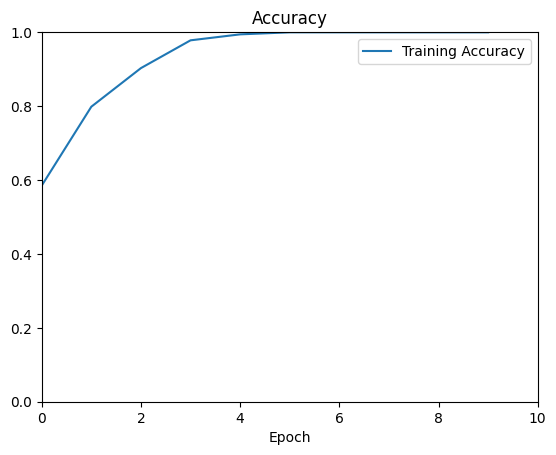

In [ ]:
# 정확도 그래프
plt.plot(hist.history['accuracy'], label='Training Accuracy')
plt.xlim(0, 10)
plt.ylim(0, 1)
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

### train['fact'] 단어 토큰화, 유사도

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2478 entries, 0 to 2477
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   ID                  2478 non-null   object
 1   first_party         2478 non-null   object
 2   second_party        2478 non-null   object
 3   facts               2478 non-null   object
 4   first_party_winner  2478 non-null   int64 
dtypes: int64(1), object(4)
memory usage: 96.9+ KB


In [ ]:
w = train[train['first_party_winner'] == 0]['facts']
l = train[train['first_party_winner'] == 1]['facts']

In [ ]:
winner, loser = [], []

for line in w:
  winner.append(line.split(" "))

for line in l:
  loser.append(line.split(" "))

In [ ]:
winner = sum(winner, [])
loser = sum(loser, [])

In [ ]:
from collections import Counter

# counter를 이용해 각 단어의 개수.
counter1 = Counter(winner)
counter2 = Counter(loser)

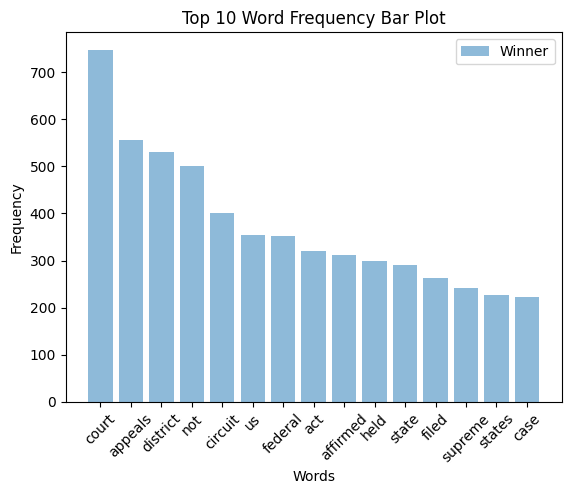

In [ ]:
top_10_winner = dict(counter1.most_common(15))
top_10_loser = dict(counter2.most_common(15))

# Bar plot 그리기
plt.bar(top_10_winner.keys(), top_10_winner.values(), alpha=0.5, label='Winner')

# 그래프에 라벨 추가
plt.xlabel('Words')
plt.xticks(rotation = 45)
plt.ylabel('Frequency')
plt.title('Top 10 Word Frequency Bar Plot')
plt.legend()

# 그래프 보이기
plt.show()

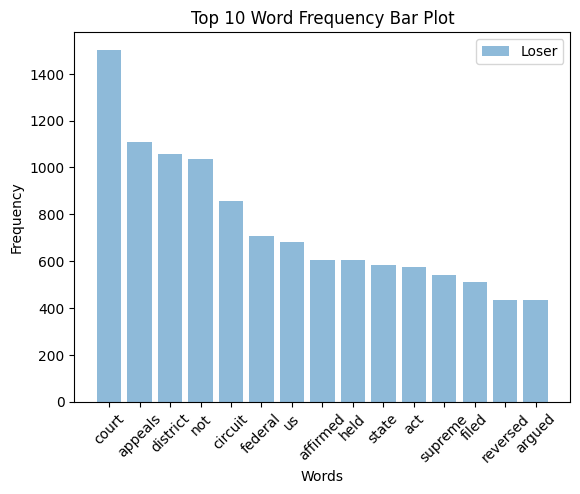

In [ ]:
plt.bar(top_10_loser.keys(), top_10_loser.values(), alpha=0.5, label='Loser')

# 그래프에 라벨 추가
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.xticks(rotation = 45)
plt.title('Top 10 Word Frequency Bar Plot')
plt.legend()

# 그래프 보이기
plt.show()